In [150]:
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'

sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            # TWO CONDITIONS
            if len(data) >= 10:
                if max(data['Loss'].values) < 5:
                    sequences.append(data['Loss'].values)
        except:
            print(filename)

flattened = list(itertools.chain(*sequences))
mean, std = np.mean(flattened), np.std(flattened)
print("number of sequences:", len(sequences), "mean:", mean, "std:", std)

number of sequences: 464 mean: 0.7416274629705124 std: 0.5634034379837275


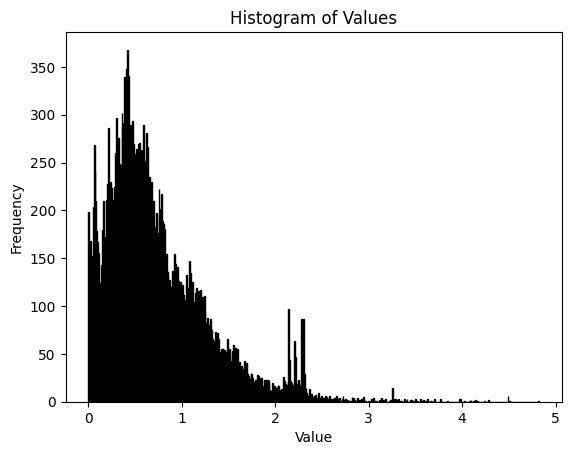

In [151]:
import matplotlib.pyplot as plt

plt.hist(flattened, bins=500, edgecolor='black')  # 'bins' specifies the number of bins

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Show the plot
plt.show()

In [136]:


input_window = 10   
output_window = 1  
X, y, X_sorted, y_sorted = list(), list(), list(), list()

for sequence in sequences:
    seq_mod_X, seq_mod_y = list(), list()
    
    for i in range(len(sequence) - input_window - output_window):
        sequence_x_temp = sequence[i:i+input_window]
        sequence_y_temp = sequence[i+input_window:i+input_window+output_window]
        sequence_x_temp = (sequence_x_temp - mean) / std # STANDARDIZATION
        sequence_y_temp = (sequence_y_temp - mean) / std # STANDARDIZATION
        
        X.append(sequence_x_temp)
        y.append(sequence_y_temp)
        seq_mod_X.append(sequence_x_temp)
        seq_mod_y.append(sequence_y_temp)
    X_sorted.append(seq_mod_X)
    y_sorted.append(seq_mod_y)

X_full = np.array(X)
y_full = np.array(y)
X_full.shape, y_full.shape


array([0.00222078, 0.00205884, 0.00137059, 0.00117266, 0.00138408,
       0.00126712, 0.00109169, 0.00089825, 0.00082628, 0.00055188])

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Custom Dataset class with scaled data
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        input_sequence = self.X[idx]
        target_value = self.y[idx]
        return torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(-1), torch.tensor(target_value, dtype=torch.float32)

# Adjusted model definition with Batch Normalization and higher embedding dimension
class FloatSequenceTransformer(nn.Module):
    def __init__(self, seq_length=10, embedding_dim=128, num_heads=4, num_layers=6, dropout=0.2):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.batch_norm = nn.BatchNorm1d(seq_length)  # Batch normalization applied after embedding
        self.register_buffer("positional_encoding", generate_positional_encoding(seq_length, embedding_dim))
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, 
                                                       batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embedding_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding

        mask = torch.triu(torch.ones(x.size(1), x.size(1)) * float('-inf'), diagonal=1)
        x = self.transformer(x, mask=mask)
        
        x = self.output_layer(x[:, -1, :])
        return x

# Positional encoding function (defined previously)
def generate_positional_encoding(seq_length, embedding_dim):
    position = torch.arange(seq_length).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    
    pe = torch.zeros(seq_length, embedding_dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Data Preparation with normalized X
train_dataset = SequenceDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model, Loss, and Optimizer
model = FloatSequenceTransformer(seq_length=10)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [23]:
from tqdm import tqdm

num_epochs = 20

# Training Loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

  5%|████                                                                              | 1/20 [02:42<51:31, 162.69s/it]

Epoch [1/20], Train Loss: 0.1335


 10%|████████▏                                                                         | 2/20 [05:31<49:50, 166.13s/it]

Epoch [2/20], Train Loss: 0.2382


 15%|████████████▎                                                                     | 3/20 [08:18<47:16, 166.84s/it]

Epoch [3/20], Train Loss: 0.2478


 20%|████████████████▍                                                                 | 4/20 [11:11<45:03, 168.95s/it]

Epoch [4/20], Train Loss: 0.2478


 25%|████████████████████▌                                                             | 5/20 [14:01<42:19, 169.30s/it]

Epoch [5/20], Train Loss: 0.2477


 30%|████████████████████████▌                                                         | 6/20 [16:51<39:34, 169.62s/it]

Epoch [6/20], Train Loss: 0.2474


 35%|████████████████████████████▋                                                     | 7/20 [19:40<36:41, 169.38s/it]

Epoch [7/20], Train Loss: 0.2475


 40%|████████████████████████████████▊                                                 | 8/20 [22:30<33:54, 169.57s/it]

Epoch [8/20], Train Loss: 0.2474


 45%|████████████████████████████████████▉                                             | 9/20 [25:17<30:57, 168.86s/it]

Epoch [9/20], Train Loss: 0.2473


 50%|████████████████████████████████████████▌                                        | 10/20 [28:04<28:03, 168.36s/it]

Epoch [10/20], Train Loss: 0.2472


 55%|████████████████████████████████████████████▌                                    | 11/20 [30:51<25:11, 167.98s/it]

Epoch [11/20], Train Loss: 0.2472


 60%|████████████████████████████████████████████████▌                                | 12/20 [33:38<22:20, 167.54s/it]

Epoch [12/20], Train Loss: 0.2471


 65%|████████████████████████████████████████████████████▋                            | 13/20 [36:26<19:34, 167.85s/it]

Epoch [13/20], Train Loss: 0.2471


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [39:13<16:44, 167.41s/it]

Epoch [14/20], Train Loss: 0.2471


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [42:00<13:56, 167.27s/it]

Epoch [15/20], Train Loss: 0.2469


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [44:46<11:08, 167.12s/it]

Epoch [16/20], Train Loss: 0.2471


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [47:33<08:20, 166.98s/it]

Epoch [17/20], Train Loss: 0.2473


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [50:33<05:41, 170.75s/it]

Epoch [18/20], Train Loss: 0.2472


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [53:30<02:52, 172.76s/it]

Epoch [19/20], Train Loss: 0.2471


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [56:24<00:00, 169.23s/it]

Epoch [20/20], Train Loss: 0.2470


In [105]:
scaler.transform([input_x])[0]

array([ 3.26322115e-01,  1.87683206e-01,  1.23105008e-01,  7.44625043e-02,
        3.46497438e-02, -2.80318621e-04, -3.34053671e-02, -6.09951656e-02,
       -8.89408046e-02, -1.18055676e-01])

In [107]:
# Prediction on New Data
def predict_next_value(model, sequence):
    model.eval()
    with torch.no_grad():
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        prediction = model(input_sequence)
        return prediction.item()

results = []
for sequence_x, sequence_y in zip(X_sorted, y_sorted): 
    
    for input_x, y_real in zip(sequence_x, sequence_y):
        transformed_x = scaler.transform([input_x])[0]
        print(transformed_x)
        y_hat = predict_next_value(model, )
        print(y_hat, y_real)
    break


[ 3.26322115e-01  1.87683206e-01  1.23105008e-01  7.44625043e-02
  3.46497438e-02 -2.80318621e-04 -3.34053671e-02 -6.09951656e-02
 -8.89408046e-02 -1.18055676e-01]


TypeError: predict_next_value() missing 1 required positional argument: 'sequence'

In [25]:
model_save_path = "trained_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to trained_model.pth
